In [1]:
#Import packages 
import autograd.numpy as np
import math
from autograd import jacobian
from numpy import genfromtxt
import scipy
from matplotlib import pyplot as plt
import matplotlib
from matplotlib import cm
from scipy.optimize import Bounds
from mpl_toolkits.mplot3d import Axes3D
#matplotlib.rcParams['text.usetex'] = True
#matplotlib.rc('font',family ='serif',size=12)
#from palettable.colorbrewer.sequential import Blues_8
#colors = Blues_8.mpl_colormap(np.linspace(0,6))
import pandas as pd

# GOH
Gasser et al 2006(https://doi.org/10.1098/rsif.2005.0073)


Incompressible material assumption
$$\Psi_1(J) = p(1-J)$$
$$\Psi_2(\mathbf{C}) = \frac{\mu}{2}(I_1 -3) +\frac{k_1}{2k_2}[e^{(k_2[\kappa I_1 + (1-3\kappa)I_4-1]^2)}-1]$$
Here $I_4 = \mathbf{C}:\mathbf{M} =\mathbf{C}:  \mathbf{a}_0\otimes \mathbf{a}_0$

Let $\mathbf{H} =\kappa \mathbf{I} + (1-3\kappa)\mathbf{M}$ 

and $H = \mathbf{H}:\mathbf{C}  =\kappa I_1 + (1-3\kappa)I_4$ and $E = [{H}-1]$

$$\mathbf{S}_1  = 2\frac{\partial \Psi_{1}}{\partial \mathbf{C}} = -pC^{-1} $$
$$\mathbf{S}_2  =  2\frac{\partial \Psi_{2}}{\partial \mathbf{C}} = \mu \mathbf{I} + 2k_1 e^{k_2{E}^2}[\kappa \mathbf{I}+(1-3\kappa)\mathbf{M}]$$

Total PK2 stress

$$\mathbf{S} = -p\mathbf{C}^{-1} +  \mu\mathbf{I} + 2k_1 e^{k_2{E}^2}{E}[\kappa \mathbf{I}+(1-3\kappa)\mathbf{M}]$$

Total PK1 stress

$$\mathbf{P} = \mathbf{F}\mathbf{S}$$

In [2]:
def evalP(par,lam1,lam2):
    mu = par[0]
    k1 = par[1]
    k2 = par[2]
    kappa = par[3]
    alpha = par[4]
    
    #Structure tensor
    a0 = np.array([np.cos(alpha),np.sin(alpha),0])
    M = np.outer(a0,a0)
    
    #Kinematics
    lam3 = 1/(lam1*lam2)
    F = np.array([[lam1 ,0., 0],[0.,lam2, 0] ,[0., 0,lam3]])
#     C = np.array([[lam1 ,0, 0],[0,lam2, 0] ,[0, 0, lam3]])
    C = F.T*F
    invF = np.linalg.inv(F)
    invC = np.linalg.inv(C)
    I = np.eye(3)
    
    #Invariants
    I1 = np.trace(C)
    I4 = np.tensordot(C,M)
    
    
    #Evaluate stress
    H = kappa*I1+(1-3*kappa)*I4
    E = H-1
    S2 = mu*I+2*k1*np.exp(k2*E**2)*E*(kappa*I+(1-3*kappa)*M)
    p = S2[2,2]/invC[2,2] #Get pressure  by equating S_33=0
    S = -p*invC+S2
    
    P =  F*S
    return P

In [3]:
A_Offx='P12AC1S1_OffX.csv'
A_Offy='P12AC1S1_OffY.csv'
A_Equi='P12AC1S1_Equibiaxial.csv'
A_Sx = 'P12AC1S1_StripX.csv'
A_Sy = 'P12AC1S1_StripY.csv'

AX = genfromtxt(A_Offx,delimiter=',')
AX = AX[:-3] #remove bad data points
AY = genfromtxt(A_Offy,delimiter=',')
AE = genfromtxt(A_Equi,delimiter=',')
AE = AE[:-20]
ASX =  genfromtxt(A_Sx,delimiter=',')
ASY =  genfromtxt(A_Sy,delimiter=',')
ASY = ASY[:-29]

A = np.vstack([AX,AY,AE,ASX, ASY])

n_offx = AX.shape[0]
n_offy = AY.shape[0]
n_equi = AE.shape[0]
n_strx = ASX.shape[0]
n_stry = ASY.shape[0]
print("n_offx: %i \n n_offy: %i \n n_equi: %i \n n_strx: %i \n n_stry: %i" %(n_offx, n_offy, n_equi, n_strx, n_stry))

n_offx: 72 
 n_offy: 76 
 n_equi: 81 
 n_strx: 101 
 n_stry: 72


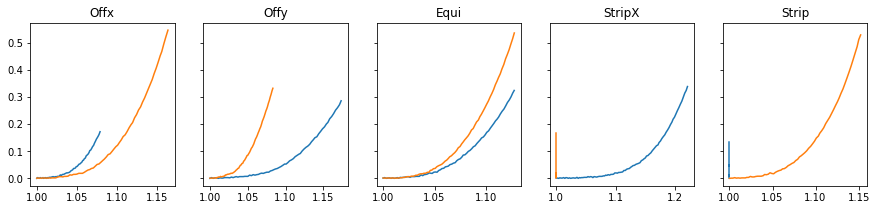

In [4]:
fig,ax = plt.subplots(1,5,figsize=(15,3),sharey=True)
ax[0].plot(AX[:,0],AX[:,1])
ax[0].plot(AX[:,2],AX[:,3])
ax[0].set_title("Offx")
ax[1].plot(AY[:,0],AY[:,1])
ax[1].plot(AY[:,2],AY[:,3])
ax[1].set_title("Offy")
ax[2].plot(AE[:,0],AE[:,1])
ax[2].plot(AE[:,2],AE[:,3])
ax[2].set_title("Equi")
ax[3].plot(ASX[:,0],ASX[:,1])
ax[3].plot(ASX[:,2],ASX[:,3])
ax[3].set_title("StripX")
ax[4].plot(ASY[:,0],ASY[:,1])
ax[4].plot(ASY[:,2],ASY[:,3])
ax[4].set_title("Strip")
plt.show()

Let's merge the data frames together for data fitting

In [5]:
def plot_outputs(title):
    fig,ax = plt.subplots(1,5,figsize=(15,3),sharey=True)


    lam1_1 = AX[:,0]
    lam1_2 = AX[:,2]
    PE1_1 = AX[:,1]
    PE1_2 = AX[:,3]
    Parr1 = np.zeros([len(lam1_1),2])
    for i in range(0,len(lam1_1)):
            P = evalP(optA.x,lam1_1[i],lam1_2[i])
            Parr1[i,0] = P[0,0]
            Parr1[i,1] = P[1,1]


    lam2_1 = AY[:,0]
    lam2_2 = AY[:,2]
    PE2_1 = AY[:,1]
    PE2_2 = AY[:,3]
    Parr2 = np.zeros([len(lam2_1),2])
    for i in range(0,len(lam2_1)):
            P = evalP(optA.x,lam2_1[i],lam2_2[i])
            Parr2[i,0] = P[0,0]
            Parr2[i,1] = P[1,1]

    lam3_1 = AE[:,0]
    lam3_2 = AE[:,2]
    PE3_1 = AE[:,1]
    PE3_2 = AE[:,3]
    Parr3 = np.zeros([len(lam3_1),2])
    for i in range(0,len(lam3_1)):
            P = evalP(optA.x,lam3_1[i],lam3_2[i])
            Parr3[i,0] = P[0,0]
            Parr3[i,1] = P[1,1]


    lam4_1 = ASX[:,0]
    lam4_2 = ASX[:,2]
    PE4_1 = ASX[:,1]
    PE4_2 = ASX[:,3]
    Parr4 = np.zeros([len(lam4_1),2])
    for i in range(0,len(lam4_1)):
            P = evalP(optA.x,lam4_1[i],lam4_2[i])
            Parr4[i,0] = P[0,0]
            Parr4[i,1] = P[1,1]        


    lam5_1 = ASY[:,0]
    lam5_2 = ASY[:,2]
    PE5_1 = ASY[:,1]
    PE5_2 = ASY[:,3]
    Parr5 = np.zeros([len(lam5_1),2])
    for i in range(0,len(lam5_1)):
            P = evalP(optA.x,lam5_1[i],lam5_2[i])
            Parr5[i,0] = P[0,0]
            Parr5[i,1] = P[1,1]        



    ax[0].plot(lam1_1,PE1_1,color='r',label=r'$\mathbf{e}_1$')       
    ax[0].plot(lam1_1,Parr1[:,0],'--',color='r')
    ax[0].plot(lam1_2,PE1_2,color='b',label=r'$\mathbf{e}_2$')       
    ax[0].plot(lam1_2,Parr1[:,1],'--',color='b') 
    ax[0].set_title("OffX")
    ax[0].set_xlabel(r'Stretch $\lambda$')
    ax[0].set_ylabel(r'Nominal Stress $P$[MPa]')
    ax[0].legend()

    ax[1].plot(lam2_1,PE2_1,color='r',label=r'$\mathbf{e}_1$')       
    ax[1].plot(lam2_1,Parr2[:,0],'--',color='r')
    ax[1].plot(lam2_2,PE2_2,color='b',label=r'$\mathbf{e}_2$')       
    ax[1].plot(lam2_2,Parr2[:,1],'--',color='b')  
    ax[1].set_title("OffY")
    ax[1].set_xlabel(r'Stretch $\lambda$')
    # ax[1].set_ylabel(r'Nominal Stress $P$[MPa]')


    ax[2].plot(lam3_1,PE3_1,color='r',label=r'$\mathbf{e}_1$')       
    ax[2].plot(lam3_1,Parr3[:,0],'--',color='r')
    ax[2].plot(lam3_2,PE3_2,color='b',label=r'$\mathbf{e}_2$')       
    ax[2].plot(lam3_2,Parr3[:,1],'--',color='b')  
    ax[2].set_title("Equi")
    ax[2].set_xlabel(r'Stretch $\lambda$')
    # ax[2].set_ylabel(r'Nominal Stress $P$[MPa]')


    ax[3].plot(lam4_1,PE4_1,color='r',label=r'$\mathbf{e}_1$')       
    ax[3].plot(lam4_1,Parr4[:,0],'--',color='r')
    ax[3].plot(lam4_1,PE4_2,color='b',label=r'$\mathbf{e}_2$')       
    ax[3].plot(lam4_1,Parr4[:,1],'--',color='b')  
    ax[3].set_title("StripX")
    ax[3].set_xlabel(r'Stretch $\lambda_x$')
    # ax[2].set_ylabel(r'Nominal Stress $P$[MPa]')


    ax[4].plot(lam5_2,PE5_1,color='r',label=r'$\mathbf{e}_1$')       
    ax[4].plot(lam5_2,Parr5[:,0],'--',color='r')
    ax[4].plot(lam5_2,PE5_2,color='b',label=r'$\mathbf{e}_2$')       
    ax[4].plot(lam5_2,Parr5[:,1],'--',color='b')  
    ax[4].set_title("StripY")
    ax[4].set_xlabel(r'Stretch $\lambda_y$')

    fig.suptitle(title)
    plt.tight_layout()
    plt.savefig("Single_fiber",dpi=300)
    plt.show()

Fit on all data [ 0.         10.          3.88811399  0.30087612  1.58130081]


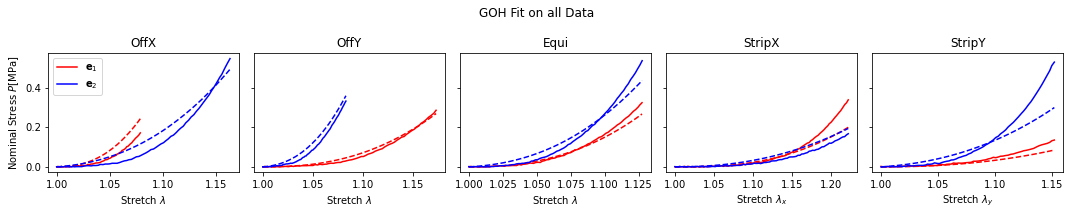

In [79]:
def ObjA(par):  
    err = 0.0 
    lam1 = A[:,0]
    lam2 = A[:,2]
    PE1 = A[:,1]
    PE2 = A[:,3]
    #Evaluate the stress and calculate error
    for i in range(0,len(lam1)):
        P = evalP(par,lam1[i],lam2[i])
        err += (P[0,0]-PE1[i])**2+ (P[1,1]-PE2[i])**2  
    return err/len(lam1)
jacA = jacobian(ObjA) # Jacobian of the objctive function using Autograd


par = [0.0001,1,1,1/10,np.pi/4] #Intial guess for the optimizer
bounds = Bounds([0.0,0.0,0.0,0.,0],[1e-2,10.,1000.,1/3,np.pi] ) #Bounds on parameters

optA = scipy.optimize.minimize(ObjA,par,jac=jacA,bounds = bounds)
print("Fit on all data",optA.x)

plot_outputs('GOH Fit on all Data')

Fit on offx and offy only [0.         9.24894751 3.36772826 0.30367759 1.57094141]


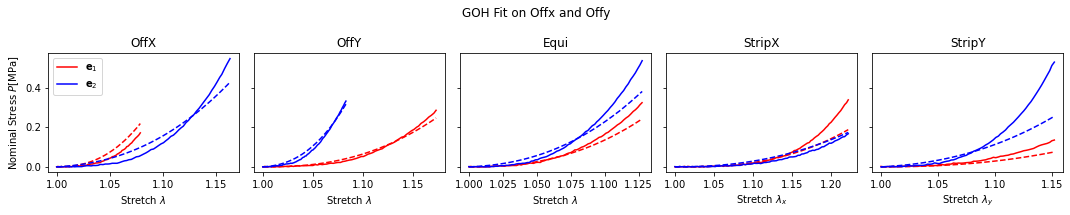

In [80]:
def ObjA(par):  
    err = 0.0 
    lam1 = A[:72+76,0]
    lam2 = A[:72+76,2]
    PE1 = A[:72+76,1]
    PE2 = A[:72+76,3]
    #Evaluate the stress and calculate error
    for i in range(0,len(lam1)):
        P = evalP(par,lam1[i],lam2[i])
        err += (P[0,0]-PE1[i])**2+ (P[1,1]-PE2[i])**2  
    return err/len(lam1)
jacA = jacobian(ObjA) # Jacobian of the objctive function using Autograd


par = [0.0001,1,1,1/10,np.pi/4] #Intial guess for the optimizer
bounds = Bounds([0.0,0.0,0.0,0.,0],[1e-2,10.,1000.,1/3,np.pi] ) #Bounds on parameters

optA = scipy.optimize.minimize(ObjA,par,jac=jacA,bounds = bounds)
print("Fit on offx and offy only",optA.x)

plot_outputs('GOH Fit on Offx and Offy')

Fit on offx + offy + equibiaxial [ 0.          7.70454001 81.45413033  0.30407081  1.57111209]


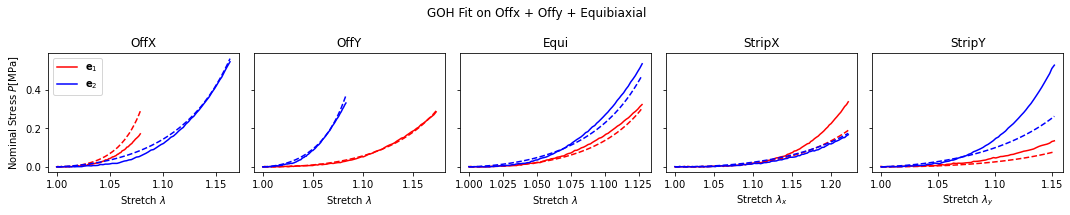

In [82]:
def ObjA(par):  
    err = 0.0 
    lam1 = A[:72+76+81,0]
    lam2 = A[:72+76+81,2]
    PE1 = A[:72+76+81,1]
    PE2 = A[:72+76+81,3]
    #Evaluate the stress and calculate error
    for i in range(0,len(lam1)):
        P = evalP(par,lam1[i],lam2[i])
        err += (P[0,0]-PE1[i])**2+ (P[1,1]-PE2[i])**2  
    return err/len(lam1)
jacA = jacobian(ObjA) # Jacobian of the objctive function using Autograd


par = [0.0001,1,1,1/10,np.pi/4] #Intial guess for the optimizer
bounds = Bounds([0.0,0.0,0.0,0.,0],[1e-2,10.,1000.,1/3,np.pi] ) #Bounds on parameters

optA = scipy.optimize.minimize(ObjA,par,jac=jacA,bounds = bounds)
print("Fit on offx + offy + equibiaxial",optA.x)

plot_outputs('GOH Fit on Offx + Offy + Equibiaxial')

Fit on offx + offy + stripx + stripy [ 0.         10.0699847   2.92145503  0.30207647  1.57084425]


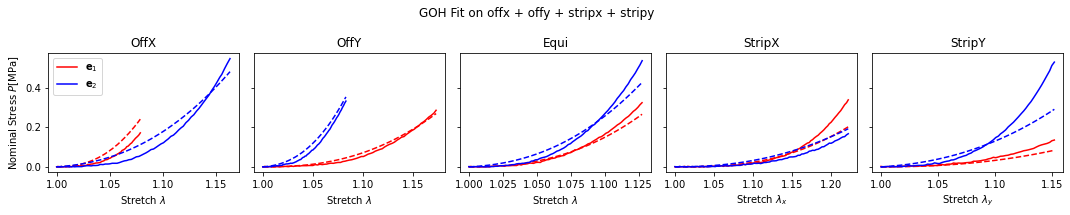

In [85]:
def ObjA(par):  
    err = 0.0 
    mask = np.ones(A.shape[0], dtype=bool)
    mask[72+76:72+76+81] = 0
    lam1 = A[mask,0]
    lam2 = A[mask,2]
    PE1 = A[mask,1]
    PE2 = A[mask,3]
    #Evaluate the stress and calculate error
    for i in range(0,len(lam1)):
        P = evalP(par,lam1[i],lam2[i])
        err += (P[0,0]-PE1[i])**2+ (P[1,1]-PE2[i])**2  
    return err/len(lam1)
jacA = jacobian(ObjA) # Jacobian of the objctive function using Autograd


par = [0.0001,1,1,1/10,np.pi/4] #Intial guess for the optimizer
bounds = Bounds([0.0,0.0,0.0,0.,0],[1e-2,20.,1000.,1/3,np.pi] ) #Bounds on parameters

optA = scipy.optimize.minimize(ObjA,par,jac=jacA,bounds = bounds)
print("Fit on offx + offy + stripx + stripy",optA.x)

plot_outputs('GOH Fit on offx + offy + stripx + stripy')

Fit on stripx and stripy [ 0.         12.32983437  2.99638755  0.29977702  1.57084442]


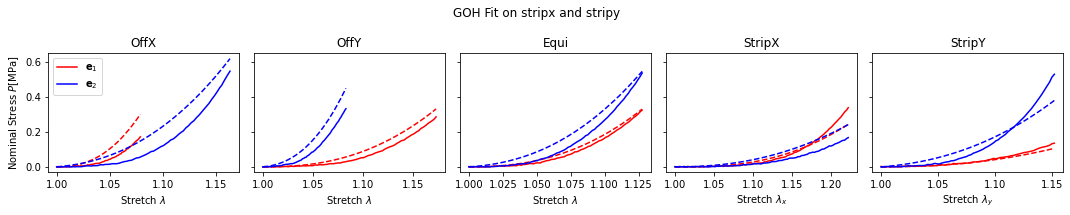

In [87]:
def ObjA(par):  
    err = 0.0 
    lam1 = A[72+76+81:,0]
    lam2 = A[72+76+81:,2]
    PE1 = A[72+76+81:,1]
    PE2 = A[72+76+81:,3]
    #Evaluate the stress and calculate error
    for i in range(0,len(lam1)):
        P = evalP(par,lam1[i],lam2[i])
        err += (P[0,0]-PE1[i])**2+ (P[1,1]-PE2[i])**2  
    return err/len(lam1)
jacA = jacobian(ObjA) # Jacobian of the objctive function using Autograd


par = [0.0001,1,1,1/10,np.pi/4] #Intial guess for the optimizer
bounds = Bounds([0.0,0.0,0.0,0.,0],[1e-2,20.,1000.,1/3,np.pi] ) #Bounds on parameters

optA = scipy.optimize.minimize(ObjA,par,jac=jacA,bounds = bounds)
print("Fit on stripx and stripy",optA.x)

plot_outputs('GOH Fit on stripx and stripy')

Fit on equibiaxial + stripx + stripy [ 0.         11.87718311  4.14343856  0.30260715  1.570626  ]


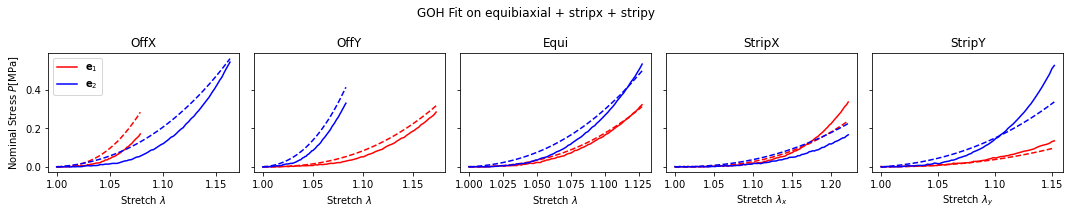

In [6]:
def ObjA(par):  
    err = 0.0 
    lam1 = A[72+76:,0]
    lam2 = A[72+76:,2]
    PE1 = A[72+76:,1]
    PE2 = A[72+76:,3]
    #Evaluate the stress and calculate error
    for i in range(0,len(lam1)):
        P = evalP(par,lam1[i],lam2[i])
        err += (P[0,0]-PE1[i])**2+ (P[1,1]-PE2[i])**2  
    return err/len(lam1)
jacA = jacobian(ObjA) # Jacobian of the objctive function using Autograd


par = [0.0001,1,1,1/10,np.pi/4] #Intial guess for the optimizer
bounds = Bounds([0.0,0.0,0.0,0.,0],[1e-2,20.,1000.,1/3,np.pi] ) #Bounds on parameters

optA = scipy.optimize.minimize(ObjA,par,jac=jacA,bounds = bounds)
print("Fit on equibiaxial + stripx + stripy",optA.x)

plot_outputs('GOH Fit on equibiaxial + stripx + stripy')